# Libor Market Model and CVA - Code Examples

In [1]:
import pandas as pd
import numpy as np

from interpolation import *
from curves import *
from correlation import *
from ratemodels import *
from volatility import *
from products import *

### Prices

Prices where extracted from Bloomberg. We use Cap volatility for 6M Libor Swaps, discounted with OIS. For simplicity, historical forward rates where computed using Bloomberg Tools.

In [2]:
cap_vol = pd.read_excel('project_data.xlsx',sheet_name='caps vol', index_col='Tenor')
t, vol = cap_vol.index.values, cap_vol.ATM.values/100
historical_rates = pd.read_excel('project_data.xlsx',sheet_name='historical f', index_col='Date')
cds_spreads = pd.read_excel('project_data.xlsx',sheet_name='jpm cds', index_col = 'Tenor')

### Enviroment Options

In this step we set global settings regarding the way we want to interpolate the date we use, the last tenor of the simulation in the LMM (T parameter), and the number of factor we want to use from the correlation factor decomposition.

In terms of interpolation, 3 types were implemented:
   * Linear - kernel: linear
   * Monotonic Cubic Spline - kernel: MCS
   * Cubic Spline - kernel: CS

In [3]:
T = 5
options = {'r_interp':  {'kernel':'MCS','extrapolate':True},
           'df_interp': {'kernel':'MCS','extrapolate':True},
           'vol_interp':{'kernel':'MCS','extrapolate':True},
           'T': T, #last tenor of the simulation in years
           'corr_factors': 4}

yf = np.arange(0,T+0.5,0.5) #for plotting porpuses

### Curves

For the needed curves, for simplicity we use QuantLib for the rates curves and implement a handler that let us work with numpy arrays. The CDS Curve was implemented from scratch.

In [4]:
libor_curve, ois_curve = curve_builder()
cds_curve = CDSCurve(ois_curve, options)
cds_curve.bootstrap(cds_spreads.index.values,cds_spreads.Spread.values/10000)

spot_data = {'ois_curve': ois_curve,
             'libor_curve':libor_curve,
             'cap_vol': (t, vol),
             'historical_rates': historical_rates}

### Libor Market Model Setup

The LiborMarketModel class containes 3 methods:

   * Constructor: recieves the global options that will be passed to the internal classes.
   * calibrate: creates intances of the classes needed to be used by the model:
       - CapletVolStrip: Boostraps the caplet volatility from Caps.
       - ParametricVolatility: Fits a parametric form to the caplet volatility.
       - CorrelationReduction: Does factor reduction to the historical correlation matrix, using the most significan N eigenvectors.
   
   * simulate: produces the curves simulation. Return a matrix of shape Tenors x Tenors x n_sim.

In [5]:
model = LiborMarketModel(options)
model.calibrate(spot_data)
model.simulate(n_sim=100000)

100%|████████████████████████████████████████████████████████████████████████| 100000/100000 [01:39<00:00, 1001.04it/s]


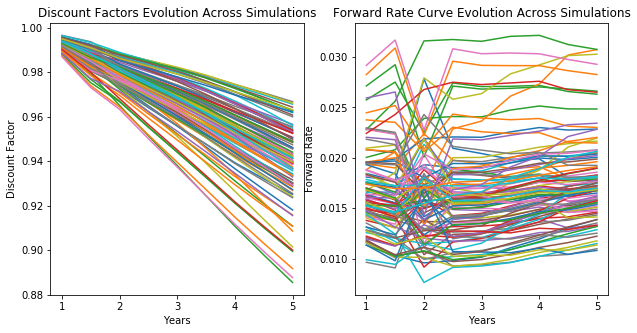

In [6]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.title('Discount Factors Evolution Across Simulations')
plt.xlabel('Years')
plt.ylabel('Discount Factor')
plt.plot(yf[1:], model.P_OIS[1,:,:100])

plt.subplot(1,2,2)
plt.title('Forward Rate Curve Evolution Across Simulations')
plt.xlabel('Years')
plt.ylabel('Forward Rate')
plt.plot(yf[1:], model.f[1,:,:100])

plt.show()

### Swap Setup

In [7]:
swap = IRS(years=T, model=model, side = 0)
EE, NEE, EPE, ENE, CVA = swap.CVA(cds_curve, ois_curve)
notional = 10000000

#Table
df = pd.DataFrame({'Swap Years':[swap.years],'Par Rate(%)':[swap.fixed_rate*100],'Notional':[notional],'EPE':[EPE*notional],'ENE':[ENE*notional], 'CVA':[CVA*notional]},index=['JP Morgan'])
df.index.name = 'Counterparty'
df

,Swap Years,Par Rate(%),Notional,EPE,ENE,CVA
Counterparty,,,,,,
JP Morgan,5,1.774517,10000000,67300.666879,-71281.79036,984.912236


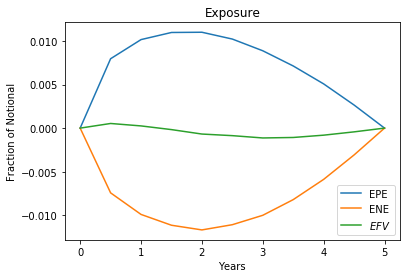

In [8]:
plt.plot(yf,EE, label='EPE')
plt.plot(yf,NEE, label='ENE')
plt.plot(yf,(EE+NEE), label=r'$EFV$')
plt.xlabel('Years')
plt.ylabel('Fraction of Notional')
plt.legend(loc='lower right')
plt.title('Exposure')
plt.show()